# 解析
- ベンチマークデータ(Social)自体の解析

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from reserch_utils_HT import degree_hist

## ベンチマークデータの解析

In [ ]:
# ベンチマーク ネットワークデータ収集
from collections import Counter
from lmfit.models import PowerLawModel
from scipy.stats import skew, kurtosis

def power_law_fit(G):
    """ degree dist fitting """
    c = Counter(dict(G.degree()).values())
    score_sorted = sorted(c.items(), key=lambda x:x[0])
    x = [k for k, v in score_sorted if k!=0]
    y = [v for k, v in score_sorted if k!=0]
    model = PowerLawModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    return result.values

def net_info(G):
    def __average_path_len(G):
        if nx.is_connected(G):
            return nx.average_shortest_path_length(G)
        else:
            return None
    
    try:
        beta = power_law_fit(G)['exponent']
    except:
        beta = None
    
    degs = np.array(list(dict(G.degree()).values()))
    info = {
        "max_degree" : max(degs),
        "min_degree" : min(degs),
        "average_degree": np.average(degs),
        "num_nodes": nx.number_of_nodes(G),
        "num_edges" : nx.number_of_edges(G),
        "beta" : beta, # べきfittingの指数
        "variance" : np.var(degs,ddof=1),
        "mode" : Counter(degs).most_common()[0][0],
        "Skewness": skew(degs),  # 歪度
        "Kurtosis": kurtosis(degs),  # 尖度
        "average_cluster": nx.average_clustering(G),  # 平均クラスター
        "average_shortest_path": __average_path_len(G)  # 平均最短経路長
    }
    return info

for name in ["COLLAB", "REDDIT-BINARY"]:
    df = pd.DataFrame()
    for parent in glob(f"../data/TUDataset/{name}/graph_data/*"):
        label = parent.split("/")[-1]
        if label != "100_graph":
            label = int(label)
            for path in tqdm(glob(f"{parent}/*.adjlist")):
                G = nx.read_adjlist(path)
                index = int(path.split("/")[-1].replace(".adjlist", ""))
                info = net_info(G)
                info["label"] = label
                info["index"] = index
                df = df.append(info, ignore_index=True)
    df.to_csv(f"../data/TUDataset/{name}/dataset_info.csv", index=False)

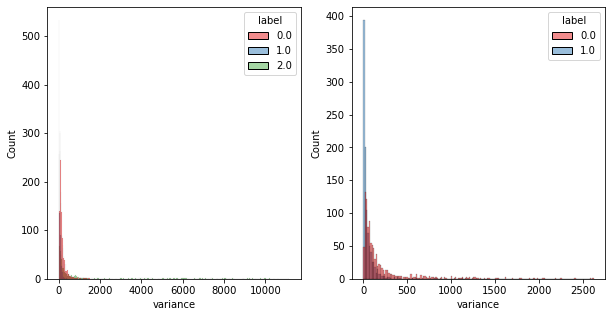

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
for i, name in enumerate(["COLLAB", "REDDIT-BINARY"]):
    df = pd.read_csv(f"../data/TUDataset/{name}/dataset_info.csv")
    sns.histplot(data=df, x="variance",  hue="label", ax=axes[i], palette="Set1")
# plt.savefig("./figs/benchmark_beta_hist.png", dpi=300)
plt.show()

In [6]:
df

,max_degree,min_degree,average_degree,num_nodes,num_edges,beta,variance,mode,Skewness,Kurtosis,average_cluster,average_shortest_path,label,index
0,27.0,1.0,2.000000,58.0,58.0,-1.462228,11.789474,1.0,6.825251,47.179741,0.000000,NaN,1.0,67.0
1,49.0,1.0,2.113208,106.0,112.0,-1.650913,22.653729,1.0,9.181887,87.591565,0.020793,NaN,1.0,1612.0
2,53.0,1.0,2.289157,83.0,95.0,-2.190044,34.159271,1.0,8.054022,67.012638,0.062503,2.622098,1.0,1984.0
3,214.0,1.0,2.668067,476.0,635.0,-1.792822,101.194852,1.0,19.620738,408.122961,0.071939,NaN,1.0,262.0
4,54.0,1.0,2.653333,150.0,199.0,-1.599797,22.724653,1.0,8.626107,88.399495,0.044044,NaN,1.0,1637.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,91.0,1.0,2.444444,738.0,902.0,-1.836375,19.612242,1.0,12.427102,223.582524,0.018304,NaN,0.0,563.0
1996,45.0,1.0,2.079208,101.0,105.0,-1.663363,20.093663,1.0,8.869477,81.970480,0.007171,NaN,0.0,1423.0
1997,243.0,1.0,2.203822,314.0,346.0,-2.508107,186.948739,1.0,17.479384,305.315168,0.048935,2.617916,0.0,737.0
1998,634.0,1.0,2.277099,1227.0,1397.0,-2.466677,330.866057,1.0,34.190627,1184.596619,0.039641,NaN,0.0,508.0


## N=100 のデータ探し

In [2]:
import shutil

In [5]:
name = "COLLAB"
df = pd.read_csv(f"../data/TUDataset/{name}/dataset_info.csv")
df_100 = df.query("num_nodes==100")
for i in df_100.itertuples():
    path = f"../data/TUDataset/{name}/graph_data/{int(i.label)}/{int(i.index)}.adjlist"
    G = nx.read_adjlist(path)
    nx.write_adjlist(G, f"../data/TUDataset/{name}/graph_data/100_graph/{int(i.label)}_{int(i.index)}.adjlist")

# real data の変換

In [5]:
import sys
sys.path.append("..")
import torch
from model import Generator
from model import Discriminator
from train_utils import get_loader, label2onehot

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# config
image_size = 100
c_dim = 4
g_repeat_num = 6
g_conv_dim = 64
# set generator
model = Generator(g_conv_dim, c_dim, g_repeat_num).to(device)
model_path = "../logs/poisson/model/100000-G.ckpt"
model.load_state_dict(torch.load(model_path))

/home/frusawa-lab/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:104: UserWarning: 
GeForce RTX 3080 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the GeForce RTX 3080 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


<All keys matched successfully>

## 変換後のデータ

In [49]:
df = pd.read_csv("../logs/poisson/test_90000.csv")

In [51]:
df.head()

,Kurtosis,Skewness,average_cluster,average_degree,average_shortest_path,beta,fake_label,max_degree,min_degree,mode,num_edges,origin_label,parameter,seed,variance
0,10.907080,3.233303,0.000000,1.98,4.991313,-2.031950,origin,13.0,1.0,1.0,99.0,BA,1.0,2000.0,4.989495
1,12.253099,3.386734,0.001430,1.86,NaN,-2.487822,BA,15.0,0.0,1.0,93.0,BA,1.0,2000.0,6.121616
2,6.593354,2.425655,0.014333,1.94,NaN,-1.809543,Attach,12.0,0.0,1.0,97.0,BA,1.0,2001.0,5.269091
3,7.017129,2.253342,0.032182,1.80,NaN,-1.448053,Growth,11.0,0.0,1.0,90.0,BA,1.0,2002.0,3.252525
4,3.925849,1.717730,0.016182,2.26,NaN,-1.247728,Random,11.0,0.0,1.0,113.0,BA,1.0,2003.0,3.749899


In [70]:
def change_lineplot(path, y="beta"):
    fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
    df = pd.read_csv(path)
    for i, kind in enumerate(["BA", "Attach", "Growth"]):
        q_df = df.query("origin_label == @kind & fake_label in ['origin','BA']")
        sns.lineplot(data=q_df, x="parameter", y=y, hue="fake_label", ax=axes[i])
        axes[i].set_title(kind)
    plt.tight_layout()
    plt.show()

../logs/poisson/test_50000.csv


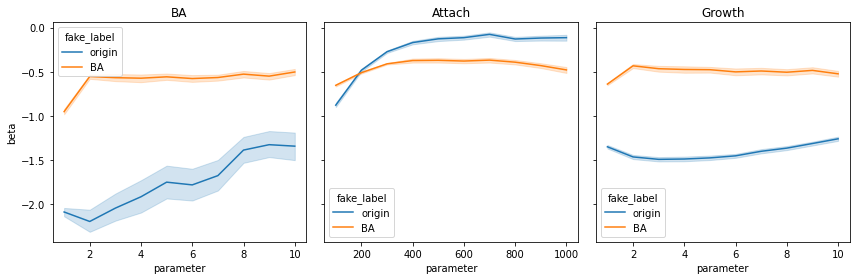

../logs/poisson/test_90000.csv


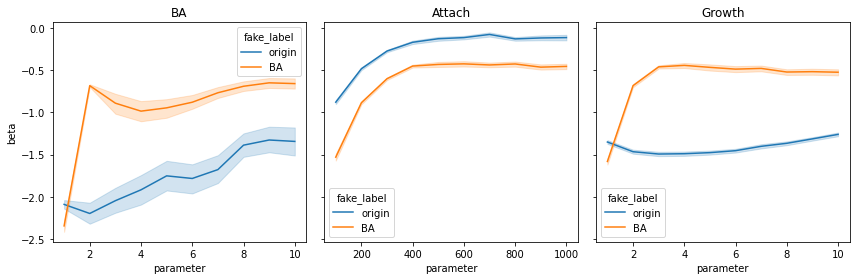

../logs/poisson/test_100000.csv


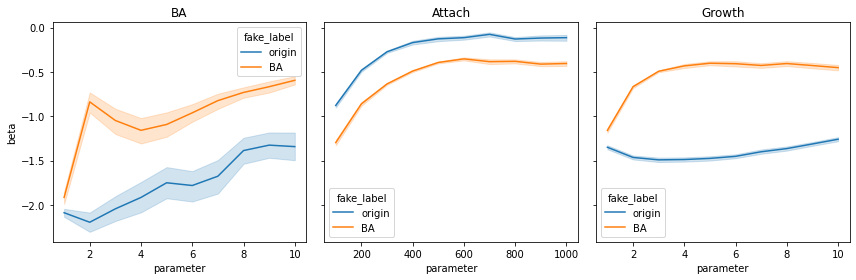

In [74]:
parent = "poisson"
for epoch in [50000, 90000, 100000]:
    print(f"../logs/{parent}/test_{epoch}.csv")
    change_lineplot(f"../logs/{parent}/test_{epoch}.csv", y="beta")

../logs/subset1/test_50000.csv


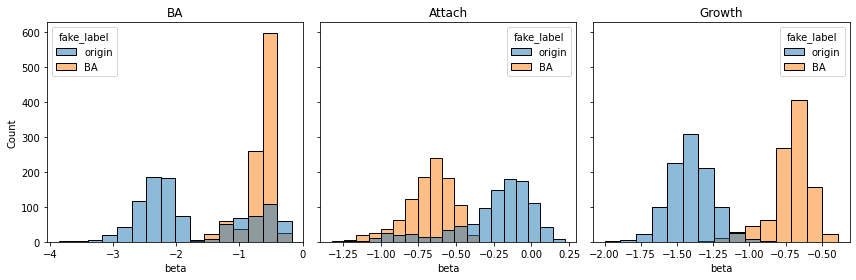

../logs/subset1/test_90000.csv


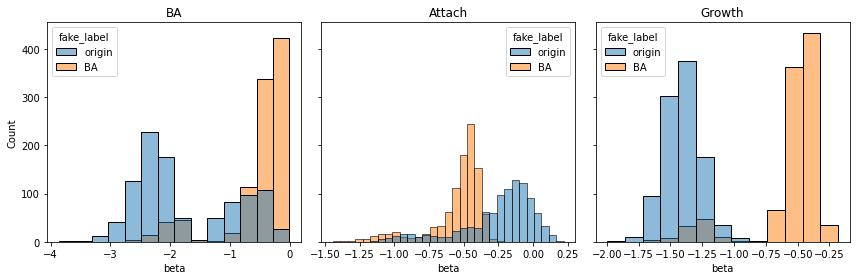

../logs/subset1/test_100000.csv


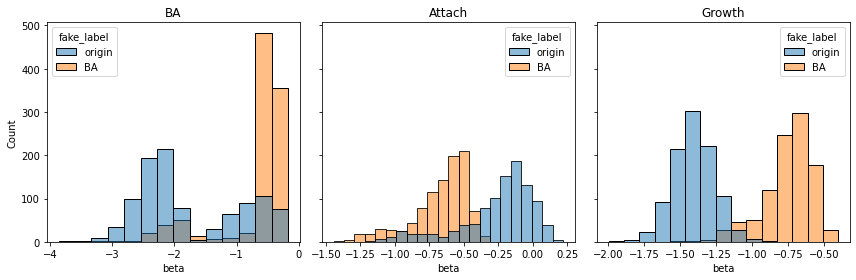

In [79]:
parent = "subset1"
for epoch in [50000, 90000, 100000]:
    print(f"../logs/{parent}/test_{epoch}.csv")
    change_lineplot(f"../logs/{parent}/test_{epoch}.csv", y="beta")

In [95]:
def change_lineplot(path, y="beta"):
    fig, axes = plt.subplots(1,3,figsize=(12,4),sharey=True)
    df = pd.read_csv(path)
    df["bet"] = df["max_degree"] - df["mode"]
    for i, kind in enumerate(["BA", "Attach", "Growth"]):
        q_df = df.query("origin_label == @kind & fake_label in ['origin','BA']")
        sns.lineplot(data=q_df, x="parameter",y=y, hue="fake_label", ax=axes[i])
        axes[i].set_title(kind)
    plt.tight_layout()
    plt.show()

../logs/subset1/test_90000.csv


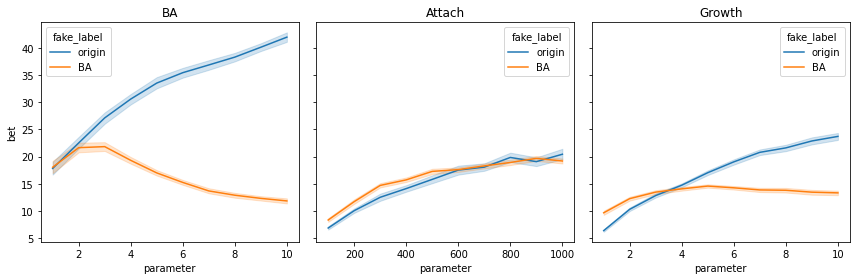

../logs/subset1_edge10/test_90000.csv


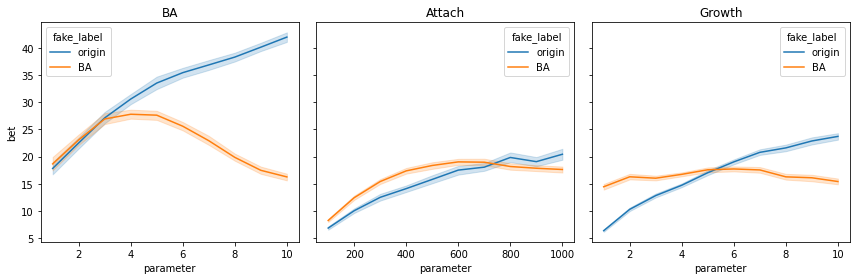

../logs/poisson/test_90000.csv


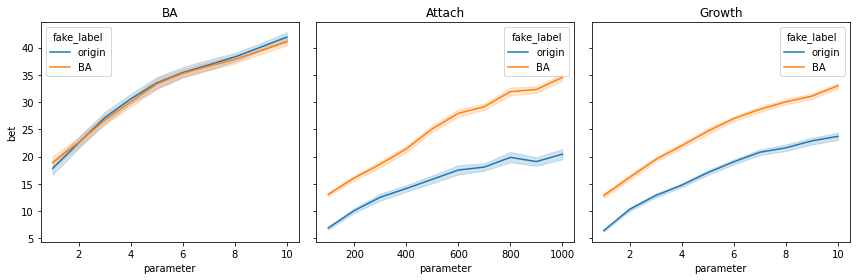

../logs/poisson_edge10/test_90000.csv


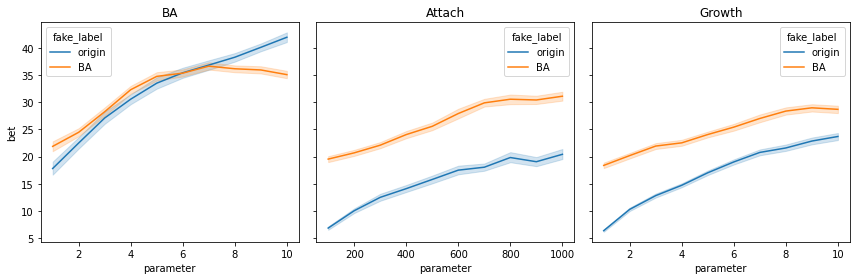

In [101]:
for parent in ["subset1", "subset1_edge10", "poisson","poisson_edge10"]:
    for epoch in [90000]:
        print(f"../logs/{parent}/test_{epoch}.csv")
        change_lineplot(f"../logs/{parent}/test_{epoch}.csv", y="bet")